In [1]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from tqdm import tqdm
import csv
from torchvision.utils import save_image
import numpy as np
from skimage.transform import PiecewiseAffineTransform, warp
from random import randrange
from numpy import asarray
from PIL import Image, ImageOps, ImageChops, ImageDraw, ImageFilter
import random

/anaconda/envs/hw_094295_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define constants
BATCH_SIZE = 16
NUM_EPOCHS = 20
LR = 0.001
np.random.seed(0)
torch.manual_seed(0)

base_dir = os.path.join("/home/student/hw2_094295", "data_original")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.ToPILImage()
rotation = transforms.Compose([transforms.Resize([120,120]), transforms.RandomRotation(20, fill=1)]) 
crop = transforms.Compose([transforms.Resize([120,120]),transforms.RandomCrop(110, padding=20)])
crop_from_PIL = transforms.Compose([transforms.PILToTensor(), transforms.Resize([120,120]),transforms.RandomCrop(110, padding=20)])
# f = open('/home/student/hw2_094295/attempts.csv', 'a')
# writer = csv.writer(f)
# writer.writerow(["description", "acc_dict", "final_acc_train", "final_acc_val"])
# f.close()

### Noise functions

In [28]:
def salt_and_pepper_augmentation(image, amount):
    output = np.copy(np.array(image))
    
    # add salt
    nb_salt = np.ceil(amount * output.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_salt)) for i in output.shape]
    output[tuple(coords)] = 255
    
    # add pepper
    nb_pepper = np.ceil(amount * output.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_pepper)) for i in output.shape]
    output[tuple(coords)] = 0
    
    return Image.fromarray(output)


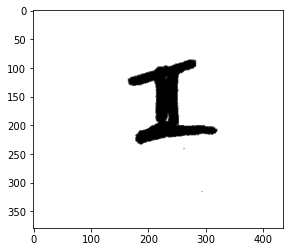

In [4]:
img = Image.open("/home/student/hw2_094295/data/train/i/ab4e0182-ce5d-11eb-b317-38f9d35ea60f.png")
plt.imshow(img, cmap="gray")
plt.show()

# Pre processing

In [3]:
def load_datasets(train_directory, val_directory, type_of_transform):
    """Loads and transforms the datasets."""

    data_transforms_with_crop = transforms.Compose([transforms.Resize([120,120]), 
                                                    transforms.ToTensor(), 
                                                    transforms.RandomCrop(110, padding=20)])
    
    data_transforms_with_rotation = transforms.Compose([transforms.Resize([120,120]), 
                                                    transforms.ToTensor(), 
                                                    transforms.RandomRotation(20, fill=1)])    
    
    data_transforms = transforms.Compose([transforms.ToTensor()])
    
    if type_of_transform == "random crop":
        # Create a pytorch dataset from a directory of images
        train_dataset = datasets.ImageFolder(train_directory, data_transforms_with_crop)
        val_dataset = datasets.ImageFolder(val_directory, data_transforms_with_crop)

    if type_of_transform == "random rotation":
        # Create a pytorch dataset from a directory of images
        train_dataset = datasets.ImageFolder(train_directory, data_transforms_with_rotation)
        val_dataset = datasets.ImageFolder(val_directory, data_transforms_with_rotation)

    if type_of_transform == "regular":
        # Create a pytorch dataset from a directory of images
        train_dataset = datasets.ImageFolder(train_directory, data_transforms)
        val_dataset = datasets.ImageFolder(val_directory, data_transforms)
        

    return train_dataset, val_dataset


In [4]:
# Extracting class names
original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir, "random crop")
class_names = original_train_dataset.classes
print(class_names)

['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


### Saving original images by the order of the reading in the dataset

In [20]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations")
os.mkdir("/home/student/hw2_094295/augmentations/Regular")
original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir, "Regular")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/Regular", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/augmentations/Regular"

# creating images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    for dataset in [original_train_dataset, original_val_dataset]:
        indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
        for idx in indices:
            save_image(dataset[idx][0], label_dir + f"/{label}_{idx}_Regular.png")
    label_index+=1

100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


### indexing the Regular images

In [41]:
# path of dir
os.mkdir("/home/student/hw2_094295/all_augmentations/Regular")
for label in class_names:
     path = os.path.join("/home/student/hw2_094295/all_augmentations/Regular", label)
     os.mkdir(path)

dataset, _ = load_datasets("/home/student/hw2_094295/Regular", val_dir, "regular")
aug_dir = "/home/student/hw2_094295/all_augmentations/Regular"

# creating images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        save_image(dataset[idx][0], label_dir + f"/{label}_{idx}_Regular.png")
    label_index+=1

100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


### Saving images with salt&pepper noise applied

In [42]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/all_augmentations/salt_and_pepper")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/all_augmentations/salt_and_pepper", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/all_augmentations/salt_and_pepper"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        image_from_tensor = transform(dataset[idx][0]).convert('L')
        image = salt_and_pepper_augmentation(image_from_tensor, 0.4)
        image.save(f"{label_dir}/{label}_{idx}_s&p.png")
    label_index+=1


100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


### Saving images with Random crop applied

In [51]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/all_augmentations/Random_crop")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/all_augmentations/Random_crop", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/all_augmentations/Random_crop"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        save_image(crop(dataset[idx][0]), label_dir + f"/{label}_{idx}_RandomCrop.png")
    label_index+=1

100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


### Saving images with noise from other images applied

In [58]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/all_augmentations/noised_by_other")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/all_augmentations/noised_by_other", label)
     os.mkdir(path)

noise_dir = "/home/student/hw2_094295/all_augmentations/noised_by_other"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(noise_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        source_image = transform(dataset[idx][0]).convert('L')
        noise_path = "/home/student/hw2_094295/noisy_background/noise_" + str(np.random.randint(0,20))+".png"
        noise_image = Image.open(noise_path).convert('L').resize(source_image.size)

        random_choice = np.random.randint(1, 4)
        if random_choice == 1:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
        elif random_choice == 2:
            noise_image = ImageOps.mirror(noise_image)
        else:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
            noise_image = ImageOps.mirror(noise_image)

        noisy_image = Image.blend(source_image.convert('L'), noise_image, 0.3)
        noisy_image.save(f"{label_dir}/{label}_{idx}_NoiseByOther.png")

    label_index+=1


100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


### Saving images with Random Rotation of 20 degrees applied

In [61]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/all_augmentations/Random_rotation")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/all_augmentations/Random_rotation", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/all_augmentations/Random_rotation"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        save_image(rotation(dataset[idx][0]), label_dir + f"/{label}_{idx}_RandomRotation.png")
    label_index+=1

100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


### saving rotated and cropped images with salt & pepper noise

In [65]:
# # Creating folder and labels sub-folders
# os.mkdir("/home/student/hw2_094295/all_augmentations/Rotation_with_salt_and_pepper")

# for label in class_names:
#      path = os.path.join("/home/student/hw2_094295/all_augmentations/Rotation_with_salt_and_pepper", label)
#      os.mkdir(path)

# # path of dir
# aug_dir = "/home/student/hw2_094295/all_augmentations/Rotation_with_salt_and_pepper"

# # creating noised images and saving them
# label_index = 0
# for label in tqdm(class_names):
#     label_dir = os.path.join(aug_dir, label)
#     indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
#     for idx in indices:
#         image_from_tensor = transform(rotation(dataset[idx][0])).convert('L')
#         image = salt_and_pepper_augmentation(image_from_tensor, 0.4)
#         image.save(f"{label_dir}/{label}_{idx}_RandomRotationWithS&P.png")
#     label_index+=1


# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/all_augmentations/Random_crop_with_salt_and_pepper")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/all_augmentations/Random_crop_with_salt_and_pepper", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/all_augmentations/Random_crop_with_salt_and_pepper"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        image_from_tensor = transform(dataset[idx][0]).convert('L')
        sp_image = salt_and_pepper_augmentation(image_from_tensor, 0.4)
        new_tensor = crop_from_PIL(sp_image)
        image = transform(new_tensor).convert('L')
        image.save(f"{label_dir}/{label}_{idx}_RandomCropWithS&P.png")
    label_index+=1

100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


### Saving rotated and cropped images with noise from other images applied

In [66]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/all_augmentations/Rotation_with_noise_by_other")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/all_augmentations/Rotation_with_noise_by_other", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/all_augmentations/Rotation_with_noise_by_other"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        source_image = transform(rotation(dataset[idx][0])).convert('L')
        noise_path = "/home/student/hw2_094295/noisy_background/noise_" + str(np.random.randint(0,20)) + ".png"
        noise_image = Image.open(noise_path).convert('L').resize(source_image.size)

        random_choice = np.random.randint(1, 4)
        if random_choice == 1:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
        elif random_choice == 2:
            noise_image = ImageOps.mirror(noise_image)
        else:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
            noise_image = ImageOps.mirror(noise_image)

        noisy_image = Image.blend(source_image.convert('L'), noise_image, 0.3)
        noisy_image.save(f"{label_dir}/{label}_{idx}_RandomRotationWithNoiseByOther.png")
    label_index+=1


# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/all_augmentations/Random_crop_with_noise_by_other")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/all_augmentations/Random_crop_with_noise_by_other", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/all_augmentations/Random_crop_with_noise_by_other"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        source_image = transform(dataset[idx][0]).convert('L')
        noise_path = "/home/student/hw2_094295/noisy_background/noise_" + str(np.random.randint(0,20)) + ".png"
        noise_image = Image.open(noise_path).convert('L').resize(source_image.size)

        random_choice = np.random.randint(1, 4)
        if random_choice == 1:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
        elif random_choice == 2:
            noise_image = ImageOps.mirror(noise_image)
        else:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
            noise_image = ImageOps.mirror(noise_image)

        noisy_image = Image.blend(source_image.convert('L'), noise_image, 0.3)
        new_tensor = crop_from_PIL(noisy_image)
        image = transform(new_tensor).convert('L')
        image.save(f"{label_dir}/{label}_{idx}_RandomCropWithNoiseByOther.png")
    label_index+=1

100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


### Calculating mean and std of the Images to Normalize them

In [10]:
# original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir)
# train_val_sets = torch.utils.data.ConcatDataset([original_train_dataset, original_val_dataset])
# images = torch.stack([img_t for img_t, _ in train_val_sets], dim=3)
# images_mean = images.view(3, -1).mean(dim=1)
# images_std = images.view(3, -1).std(dim=1)
# print(f"images mean: {images_mean}")
# print(f"images std: {images_std}")

# Creating train and val

In [9]:
if not os.path.exists("/home/student/hw2_094295/aug_batches"):
    os.mkdir("/home/student/hw2_094295/aug_batches")

filtered_folder = "/home/student/hw2_094295/filtered_augmentations/"
aug_batches_path = "/home/student/hw2_094295/aug_batches/"
special_images_path = "/home/student/hw2_094295/aug_batches/specials/"


folders = os.listdir(filtered_folder)
for folder in folders:
    for label in tqdm(class_names):
        label_dir = os.path.join(filtered_folder + folder, label)
        files = os.listdir(label_dir)
        for file in files:
            params = file.split("_")
            file_label = params[0]
            file_index = params[1]
            if not os.path.exists(aug_batches_path + file_index + "_" + label):
                os.mkdir(aug_batches_path + file_index + "_" + label)
            Image.open(label_dir + "/" + file).save(aug_batches_path + file_index + "_" + label + "/" + file)

100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


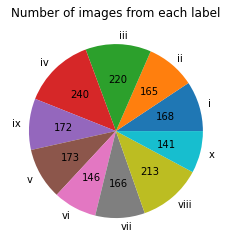

minimal size: 141
Number of regular of each label in train: 113


In [5]:
folders = os.listdir("/home/student/hw2_094295/all_augmentations/Regular/")
labels_dict = {}
for folder in folders:
    labels_dict[folder] = len(os.listdir(f"/home/student/hw2_094295/all_augmentations/Regular/{folder}"))

sizes = np.array(list(labels_dict.values()))
labels = sorted(list(labels_dict.keys()))
def absolute_value(val):
    a  = int(np.round(val/100.*sizes.sum(), 0))
    return a

plt.pie(sizes, labels=labels, autopct=absolute_value, rotatelabels=False)
plt.title("Number of images from each label")
plt.show()

min_size = min(sizes)
num_reg_in_train = round(0.8*(min(sizes)))
print(f"minimal size: {min_size}")
print(f"Number of regular of each label in train: {num_reg_in_train}")

In [6]:
dict_train_quantities = {}
dict_val_quantities = {}
dict_train = {}
dict_val = {}

for label in class_names:
    files = os.listdir(f"/home/student/hw2_094295/all_augmentations/Regular/{label}")
    to_train = random.sample(files, num_reg_in_train)
    dict_train[label] = to_train
    dict_val[label] = [file for file in files if file not in to_train]
    dict_train_quantities[label] = len(to_train)
    dict_val_quantities[label] = len([file for file in files if file not in to_train])


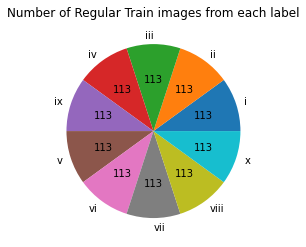

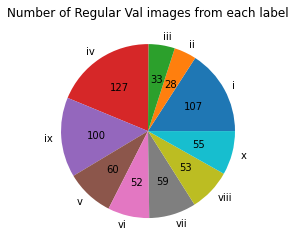

In [7]:
sizes = np.array(list(dict_train_quantities.values()))
labels = sorted(list(dict_train_quantities.keys()))
def absolute_value(val):
    a  = int(np.round(val/100.*sizes.sum(), 0))
    return a

plt.pie(sizes, labels=labels, autopct=absolute_value, rotatelabels=False)
plt.title("Number of Regular Train images from each label")
plt.show()

sizes = np.array(list(dict_val_quantities.values()))
labels = sorted(list(dict_val_quantities.keys()))
def absolute_value(val):
    a  = int(np.round(val/100.*sizes.sum(), 0))
    return a

plt.pie(sizes, labels=labels, autopct=absolute_value, rotatelabels=False)
plt.title("Number of Regular Val images from each label")
plt.show()

In [39]:
os.mkdir("/home/student/hw2_094295/data/")
os.mkdir("/home/student/hw2_094295/data/train")
os.mkdir("/home/student/hw2_094295/data/val")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/data/train", label)
     os.mkdir(path)

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/data/val", label)
     os.mkdir(path)

In [40]:
train_per = 0.7
val_per = 1-train_per

folders = os.listdir("/home/student/hw2_094295/aug_batches/")

chosen_augmentations = {}
num_available_per_folder = {}
for folder in folders:
    chosen_augmentations[folder] = []
    num_available_per_folder[folder] = len(os.listdir(f"/home/student/hw2_094295/aug_batches/{folder}"))-1

# For train
print("Building train...")
for label in tqdm(class_names):
    counter = 113
    while(counter <= train_per*1000):
        for folder in folders:
            if counter <= train_per*1000:
                params = folder.split("_")
                if params[1] == label:
                    if f"{label}_{params[0]}_Regular.png" in dict_train[label]:
                        files = os.listdir(f"/home/student/hw2_094295/aug_batches/{folder}/")
                        file = random.sample(files, 1)[0]
                        while (file == f"{label}_{params[0]}_Regular.png" or file in chosen_augmentations[folder]) and num_available_per_folder[folder] > 0:
                            file = random.sample(files, 1)[0]
                        Image.open(f"/home/student/hw2_094295/aug_batches/{folder}/{file}")\
                            .save(f"/home/student/hw2_094295/data/train/{label}/{file}")
                        chosen_augmentations[folder].append(file)
                        num_available_per_folder[folder] -= 1
                        counter += 1
            else:
                break

# For val
print("Building val...")
for label in tqdm(class_names):
    counter = 113
    while(counter <= val_per*1000):
        for folder in folders:
            if counter <= val_per*1000:
                params = folder.split("_")
                if params[1] == label:
                    if f"{label}_{params[0]}_Regular.png" in dict_val[label]:
                        files = os.listdir(f"/home/student/hw2_094295/aug_batches/{folder}/")
                        file = random.sample(files, 1)[0]
                        while (file == f"{label}_{params[0]}_Regular.png" or file in chosen_augmentations[folder]) and num_available_per_folder[folder] > 0:
                            file = random.sample(files, 1)[0]
                        Image.open(f"/home/student/hw2_094295/aug_batches/{folder}/{file}")\
                            .save(f"/home/student/hw2_094295/data/val/{label}/{file}")
                        chosen_augmentations[folder].append(file)
                        num_available_per_folder[folder] -= 1
                        counter += 1
            else:
                break

Building train...


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


Building val...


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


# Training procedure

In [30]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=100):
    """Responsible for running the training and validation phases for the requested model."""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    acc_dict = {'train': [], 'val': []}

    for epoch in tqdm(range(num_epochs)):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            acc_dict[phase].append(epoch_acc.item())
            loss_dict[phase].append(epoch_loss)

            if epoch%10 == 0:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # If the current epoch provides the best validation accuracy so far, save the model's weights.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_dict, acc_dict

In [31]:
def save_attempt_to_csv(description, acc_dict):
    f = open('/home/student/hw2_094295/attempts.csv', 'a')
    writer = csv.writer(f)
    writer.writerow([description, acc_dict, acc_dict["train"][-1], acc_dict["val"][-1]])
    f.close()

In [85]:
def run(desc_to_csv):

    # Build dataloaders
    original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir)
    train_val_sets = torch.utils.data.ConcatDataset([original_train_dataset, original_val_dataset])
    all_dataloader = torch.utils.data.DataLoader(train_val_sets, batch_size=BATCH_SIZE, shuffle=True)
    train_size = int(0.8*len(train_val_sets))
    val_size = len(train_val_sets)-train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_val_sets, [train_size, val_size])
    plt.imshow(original_train_dataset[0][0].permute(1,2,0))
    plt.show()
    raise()


    class_names = original_train_dataset.classes
    NUM_CLASSES = len(class_names)

    # Dataloaders initialization
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    dataloaders = {'train': train_dataloader, 'val': val_dataloader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    #Define model and constants
    model_ft = models.resnet50(pretrained=False)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

    # Train the model
    model_ft, loss_dict, acc_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=NUM_EPOCHS)
    save_attempt_to_csv(desc_to_csv, acc_dict)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


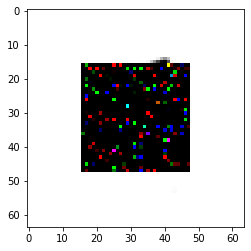

TypeError: exceptions must derive from BaseException

Bad pipe message: %s [b'\x9e\xb0\x9f\x87\xf9\xcb']
Bad pipe message: %s [b'\xc3\xbd\x9f\xc0j\xd4\xfc\xbe&\xb1\xb1bm\\\x01M\x96D\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc']
Bad pipe message: %s [b"\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00"]
Bad pipe message: %s [b'\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08']
Bad pipe message: %s [b'\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'', b'\x03\x03']
Bad pipe message: %s [b'']
Bad pipe message: %s 

In [90]:
run("with normalization, 80% train and 20% test")

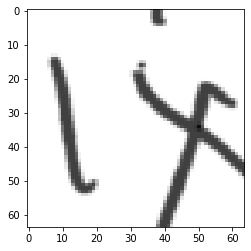

TypeError: exceptions must derive from BaseException

In [51]:
run("with normalization, 80% train and 20% test")

## Saving the model and generating accuracy and loss plots

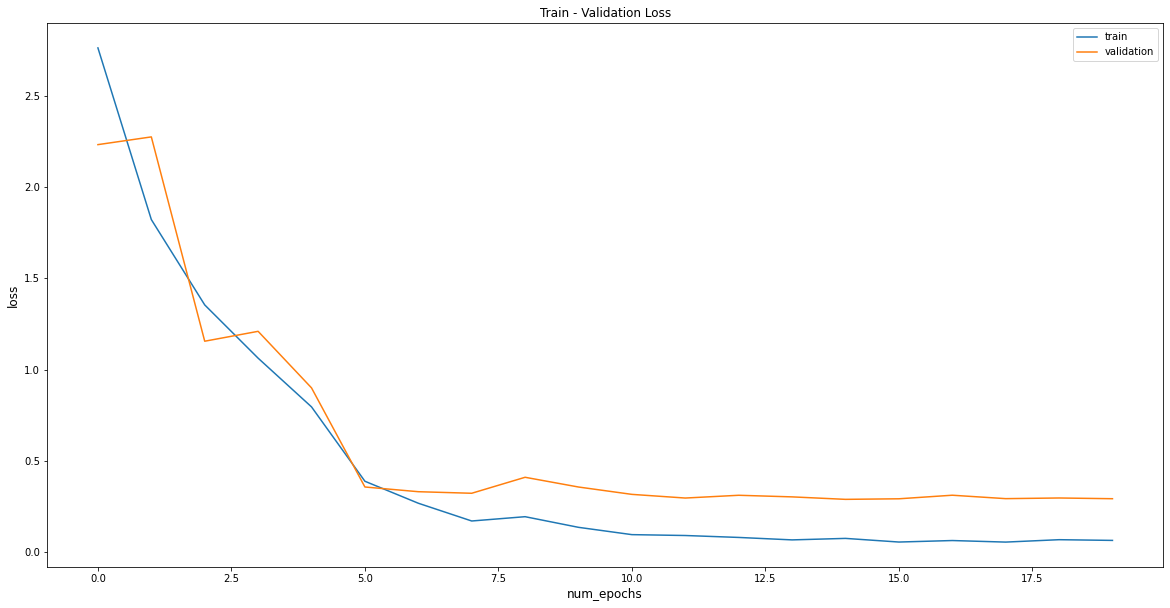

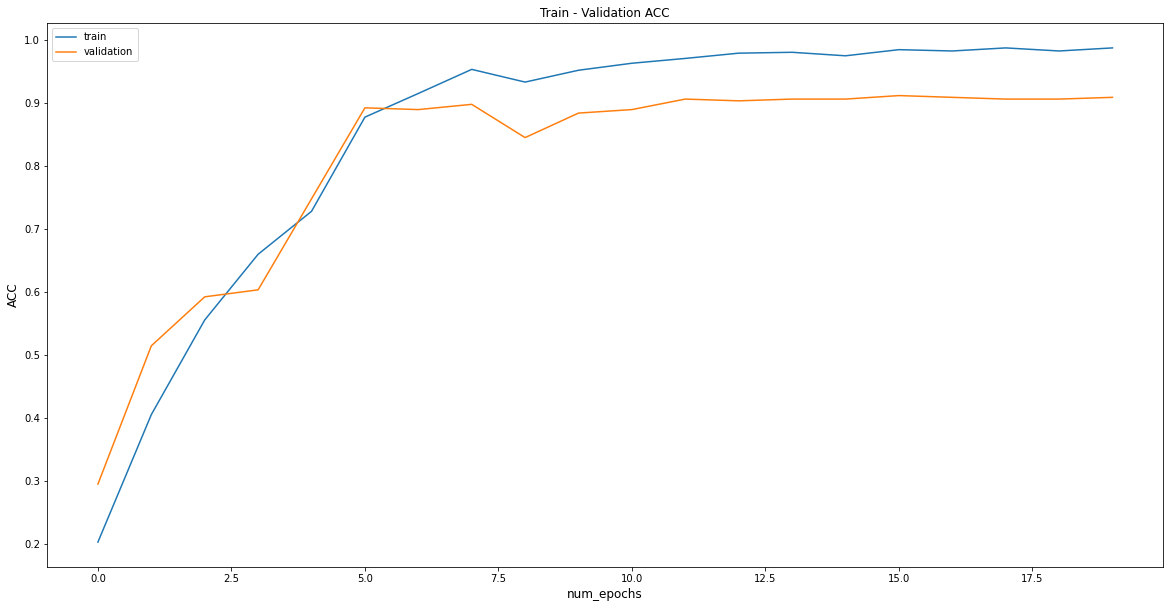

In [51]:
# Save the trained model
models_dir = os.path.join('/home/student/hw2_094295', 'models')
os.makedirs(models_dir, exist_ok=True)
torch.save(model_ft.state_dict(), os.path.join(models_dir, "trained_model.pt"))

figures_dir = os.path.join('/home/student/hw2_094295', 'figures')
os.makedirs(figures_dir, exist_ok=True)

# Basic visualizations of the model performance
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(loss_dict['train'], label='train')
plt.plot(loss_dict['val'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.savefig(os.path.join(figures_dir, 'train_val_loss_plot.png'))

fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation ACC")
plt.plot(acc_dict['train'], label='train')
plt.plot(acc_dict['val'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('ACC', fontsize=12)
plt.legend(loc='best')
plt.savefig(os.path.join(figures_dir, 'train_val_acc_plot.png'))